## Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import collections
import re
import gseapy as gp
from gseapy.plot import barplot, dotplot

import cptac.endometrial as en
import cptac.algorithms as al

Welcome to the cptac data service package. Available datasets may be
viewed using cptac.list_data(). In order to access a specific data
set, import a cptac subfolder using either 'import cptac.dataset' or
'from cptac import dataset'.
******
Version: 0.4.1
******
You have loaded the cptac endometrial dataset. To view available
dataframes, use cptac.endometrial.list_data(). To view available
functions for accessing and manipulating the dataframes, use
cptac.endometrial.list_api().
endometrial data version: 2.1

Loading Dictionary...
Loading cptac endometrial data:
Loading proteomics data...
Loading clinical data...
Loading acetylproteomics data...
Loading phosphoproteomics_site data...
Loading somatic data...
Loading transcriptomics_circular data...
Loading phosphoproteomics_gene data...
Loading transcriptomics_linear data...
Loading miRNA data...
Loading somatic_binary data...
Loading CNA data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available

## Get frequently mutated genes list

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [2]:
cancer_type = "Endometrial"
desired_cutoff = .15

fm = al.get_frequently_mutated(cancer_type, cutoff=desired_cutoff)
print(fm)

       Gene  Percent Mutated
0     RPL22         0.168421
1    ARID1A         0.452632
2    PIK3CA         0.494737
3     FBXW7         0.189474
4     RBM27         0.168421
5      NSD1         0.168421
6     SYNE1         0.168421
7     ZFHX4         0.200000
8      PTEN         0.789474
9      CTCF         0.284211
10   ZNF469         0.157895
11     TP53         0.221053
12    KMT2B         0.242105
13     KRAS         0.326316
14    LMAN1         0.157895
15    SCAF4         0.168421
16   PIK3R1         0.389474
17   CTNNB1         0.305263
18     PCLO         0.168421
19    KMT2D         0.178947
20    HERC2         0.178947
21    ZFHX3         0.221053
22     JAK1         0.168421
23    OBSCN         0.157895
24    AHNAK         0.157895
25  CCDC168         0.168421
26    DOCK3         0.200000
27    MUC16         0.189474
28    HUWE1         0.157895
29   DNAH17         0.157895
30   INPPL1         0.200000


## Select a gene from the list of frequently mutated genes above

Set the gene to which of the above frequently mutated genes you want to examine. For example, if you want to look at the gene PTEN, change the cell below to say "gene = 'PTEN'"

In [3]:
gene = 'PTEN'

## Select desired omics comparison

Select which type of omics you want to compare. If you want to compare proteomics data for the interacting proteins, uncomment the "omics = en.get_proteomics()" line, etc.

In [4]:
omics = en.get_proteomics()
#omics = en.get_transcriptomics()
#omics = en.get_phosphoproteomics()
#omics = en.get_acetylproteomics()

## TODO: Brittney, CIS Comparison Here

In [12]:
'''Cis analysis here'''

'Cis analysis here'

## Generate interacting proteins and test omics comparisons

Simply run this cell after following the instructions above to see the results of the comparisons

In [5]:
try:
    '''Prevent slice degrees of freedom warning'''
    import warnings
    warnings.filterwarnings("ignore")

    print("\nGene: ", gene)

    '''Use get interacting proteins method to generate list of interacting proteins'''
    interacting_proteins = al.get_interacting_proteins(gene)

    print("Generating interacting protein list")
    interacting_proteins_in_omics_df = []

    '''Only do comparisons on proteins in the omics dataframe'''
    for ip in interacting_proteins:
        if omics.name == 'phosphoproteomics' or omics.name == 'acetylproteomics':
            col_regex = ip + "-.*" # Build a regex to get all columns that match the gene
        else:
            col_regex = '^{}$'.format(ip)

        selected = omics.filter(regex=col_regex)

        if len(selected.columns) > 0:
            interacting_proteins_in_omics_df.append(ip)

    '''Ceate dataframe in order to do comparisons with wrap_ttest'''
    protdf = en.append_mutations_to_omics(mutation_genes=[gene], omics_df=omics, omics_genes=interacting_proteins_in_omics_df)
    protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

    '''Create the binary valued column needed to do the comparison'''
    for ind, row in protdf.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            protdf.at[ind,'Label'] = 'Mutated'
        else:
            protdf.at[ind,'Label'] = 'Wildtype'

    '''Format the datafram correctly'''
    protdf = protdf.drop(gene+"_Mutation",axis=1)
    protdf = protdf.drop(gene+"_Location",axis=1)
    protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
    protdf = protdf.drop("Sample_Status",axis=1)

    '''Make list of columns to be compared using t-tests'''
    col_list = list(protdf.columns)
    col_list.remove('Label')

    print("Doing t-test comparisons\n")

    '''Call wrap_ttest, pass in formatted dataframe'''
    wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

    '''Print results, if anything significant was found'''
    if wrap_results is not None:
            print(wrap_results)
            print("\n\n")

except:
    print("Error in Comparison")


Gene:  PTEN
Generating interacting protein list
Doing t-test comparisons

           Comparison   P_Value
0   PIK3CA_proteomics  0.000017
1  CSNK2A1_proteomics  0.000102
2     TP53_proteomics  0.000935





## Look at effect on all proteins

This will look at the effect of the selected gene mutation on all proteins, and report any significant results.

In [6]:
try:
    print("\nGene: ", gene)

    '''Use get interacting proteins method to generate list of interacting proteins'''
    proteomics = en.get_proteomics()
    proteins = proteomics.columns
    #proteins = proteins[:250]

    print("Generating protein list")
    interacting_proteins_in_omics_df = []

    '''Only do comparisons on proteins in the omics dataframe'''
    for ip in proteins:
        if omics.name == 'phosphoproteomics' or omics.name == 'acetylproteomics':
            col_regex = "^{}-.*$".format(ip) # Build a regex to get all columns that match the gene
        else:
            col_regex = '^{}$'.format(ip)

        selected = omics.filter(regex=col_regex)

        if len(selected.columns) > 0:
            interacting_proteins_in_omics_df.append(ip)

    '''Create dataframe in order to do comparisons with wrap_ttest'''
    protdf = en.append_mutations_to_omics(mutation_genes=[gene], omics_df=omics, omics_genes=interacting_proteins_in_omics_df)
    protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']
    
    '''Create the binary valued column needed to do the comparison'''
    for ind, row in protdf.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            protdf.at[ind,'Label'] = 'Mutated'
        else:
            protdf.at[ind,'Label'] = 'Wildtype'

    '''Format the datafram correctly'''
    protdf = protdf.drop(gene+"_Mutation",axis=1)
    protdf = protdf.drop(gene+"_Location",axis=1)
    protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
    protdf = protdf.drop("Sample_Status",axis=1)

    '''Make list of columns to be compared using t-tests'''
    col_list = list(protdf.columns)
    col_list.remove('Label')

    print("Doing t-test comparisons\n")
    
    '''Call wrap_ttest, pass in formatted dataframe'''
    wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

    '''Print results, if anything significant was found'''
    if wrap_results is not None:
            print(wrap_results)
            print("\n\n")

except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  PTEN
Generating protein list
Doing t-test comparisons

             Comparison       P_Value
0      NOL10_proteomics  5.611188e-11
1       ESF1_proteomics  6.691871e-10
2      CMTR1_proteomics  5.055672e-09
3      DDX52_proteomics  7.150868e-09
4       LSG1_proteomics  9.021583e-09
5       SMG8_proteomics  2.056488e-08
6       NGDN_proteomics  2.057004e-08
7      TRMT6_proteomics  2.251381e-08
8      SENP2_proteomics  2.938007e-08
9     KIF13B_proteomics  2.976583e-08
10      GRB7_proteomics  3.543120e-08
11    HEATR1_proteomics  3.573639e-08
12     USP39_proteomics  4.136375e-08
13      ABT1_proteomics  5.219925e-08
14      RIF1_proteomics  6.685617e-08
15     CMSS1_proteomics  7.327087e-08
16    ARFIP1_proteomics  7.957193e-08
17     L1CAM_proteomics  9.386578e-08
18      XPO5_proteomics  9.528731e-08
19     WDR75_proteomics  1.187857e-07
20    HOMER2_proteomics  1.323965e-07
21     CEBPZ_proteomics  1.609315e-07
22     UTP25_proteomics  2.330516e-07
23     AP1M2_proteomics  

## Gene Set Enrichment on Significant Omics Genes

In [11]:
if len(wrap_results) > 0:
    '''Get a list of the omics genes deemed significant by wrap_ttest'''
    all_gene_list = list(wrap_results['Comparison'])
    gene_name_list = []
    for agl in all_gene_list:
        split = agl.split("_")
        gene_name_list.append(split[0])
    
    '''Use the gseapy library to run a gene set enrichment analysis on the resulting list of genes'''
    enrichment = gp.enrichr(gene_list = gene_name_list, description='ARID1A_Impacted', gene_sets='KEGG_2016', outdir='test/enrichr_kegg',cutoff=.5)
    print(enrichment.res2d)
    
else:
    print("No significant comparisons found.")

     Gene_set                                               Term Overlap  \
0   KEGG_2016  Ribosome biogenesis in eukaryotes_Homo sapiens...    6/89   
1   KEGG_2016                      Measles_Homo sapiens_hsa05162   4/136   
2   KEGG_2016                  Influenza A_Homo sapiens_hsa05164   4/175   
3   KEGG_2016                  Hepatitis C_Homo sapiens_hsa05160   3/133   
4   KEGG_2016                RNA transport_Homo sapiens_hsa03013   3/172   
5   KEGG_2016     Herpes simplex infection_Homo sapiens_hsa05168   3/185   
6   KEGG_2016   Osteoclast differentiation_Homo sapiens_hsa04380   2/132   
7   KEGG_2016        Wnt signaling pathway_Homo sapiens_hsa04310   2/142   
8   KEGG_2016                  Hepatitis B_Homo sapiens_hsa05161   2/146   
9   KEGG_2016  Signaling pathways regulating pluripotency of ...   2/142   
10  KEGG_2016               Tight junction_Homo sapiens_hsa04530   2/139   
11  KEGG_2016   Jak-STAT signaling pathway_Homo sapiens_hsa04630   2/158   
12  KEGG_201

47        0.118304                     HGD;MTHFD2;ALG2  


## Plot Gene Set Enrichment Results

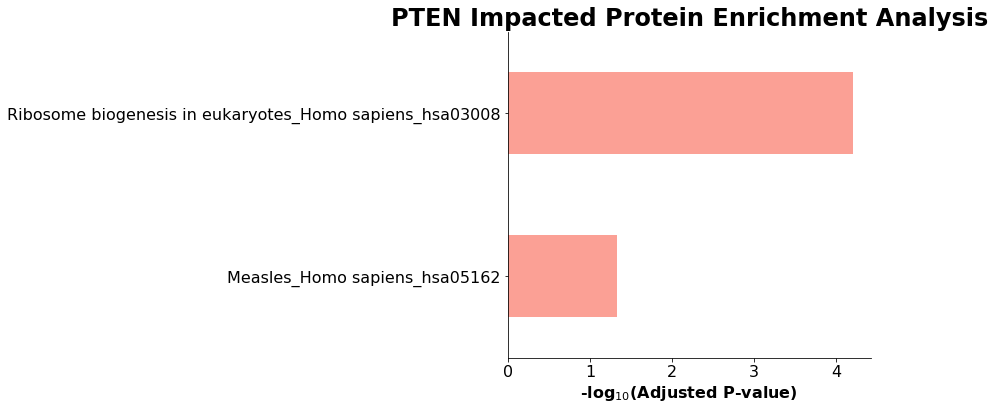

In [8]:
'''Plot the significant results of the gene set enrichment analysis'''
if len(wrap_results) > 0:
    barplot(enrichment.res2d, title=gene+ " Impacted Protein Enrichment Analysis")
else:
    print("No significant comparisons found.")